# Introduction to Robotics (2025)
## Sookmyung W. Univ.
## Lecturer: Prof. Joo Yong Sim
## Tutorial 1: Two-Link Manipulator PD Control — Tutorial


# ✅ **TUTORIAL: 🦾 Two-Link Manipulator PD Control — Full Tutorial **

### *Robotics Lecture • Kinematics • Trajectory Generation • PD Control • Simulation*

Walk through the complete process of controlling a **2-link planar manipulator** with a **joint-space PD controller**.
You will implement forward/inverse kinematics, trajectory generation, system dynamics, and closed-loop control step by step.

## 🔧 Additional Possible Experiments

* Tune PD gains and observe overshoot/settling behavior
* Switch IK to elbow-up mode
* Try circular and sinusoidal paths
* Add gravity terms to dynamics
* Compare joint-space vs workspace control


# 🦾 Two-Link Manipulator PD Control – Tutorial Overview

This tutorial simulates a 2-link planar robot arm tracking a desired end-effector trajectory using a **joint-space PD controller**.

We follow 9 steps that correspond exactly to the code structure.

A conceptual diagram of a 2-link planar robot:

![2-link planar manipulator](https://upload.wikimedia.org/wikipedia/commons/thumb/1/15/Planar_2R_Robot_Kinematics.svg/640px-Planar_2R_Robot_Kinematics.svg.png)


---

# Save the animation from Tutorial 1

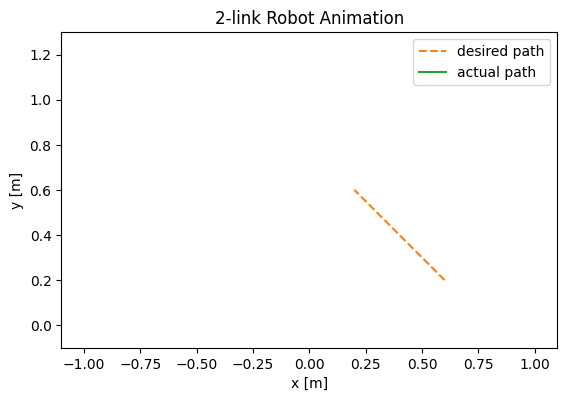

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# ======================================
# 1. Robot / Simulation Parameters
# ======================================
l1 = 0.5
l2 = 0.5

J_real = np.array([0.8, 0.5])
b_real = np.array([0.15, 0.1])

dt = 0.005          # Increase timestep slightly for animation
T_total = 2.0
N = int(T_total / dt)

time = np.arange(N) * dt

# ======================================
# 2. Forward / Inverse Kinematics
# ======================================
def fk_2link(theta1, theta2):
    x = l1 * np.cos(theta1) + l2 * np.cos(theta1 + theta2)
    y = l1 * np.sin(theta1) + l2 * np.sin(theta1 + theta2)
    return x, y

def ik_2link(x, y, elbow='down'):
    c2 = (x**2 + y**2 - l1**2 - l2**2) / (2 * l1 * l2)
    c2 = np.clip(c2, -1.0, 1.0)
    if elbow == 'down':
        s2 = -np.sqrt(1 - c2**2)
    else:
        s2 =  np.sqrt(1 - c2**2)
    theta2 = np.arctan2(s2, c2)

    k1 = l1 + l2 * c2
    k2 = l2 * s2
    theta1 = np.arctan2(y, x) - np.arctan2(k2, k1)
    return theta1, theta2

# ======================================
# 3. Desired end-effector trajectory definition
# ======================================
x_start, y_start = 0.6, 0.2
x_goal,  y_goal  = 0.2, 0.6
T_move = 1.5

def desired_xy_trajectory(t):
    if t >= T_move:
        return x_goal, y_goal
    s = t / T_move
    s_smooth = 3*s**2 - 2*s**3
    x_d = x_start + (x_goal - x_start) * s_smooth
    y_d = y_start + (y_goal - y_start) * s_smooth
    return x_d, y_d

# ======================================
# 4. Desired joint trajectory (theta_d, dtheta_d)
# ======================================
theta_d = np.zeros((N, 2))
for k in range(N):
    t = time[k]
    xd, yd = desired_xy_trajectory(t)
    th1_d, th2_d = ik_2link(xd, yd, elbow='down')
    theta_d[k] = [th1_d, th2_d]

theta_d_dot = np.gradient(theta_d, dt, axis=0)

# ======================================
# 5. Plant dynamics & PD controller
# ======================================
def plant_step(theta, theta_dot, tau):
    ddtheta = (tau - b_real * theta_dot) / J_real
    theta_dot_new = theta_dot + ddtheta * dt
    theta_new = theta + theta_dot_new * dt
    return theta_new, theta_dot_new

Kp = np.array([80.0, 60.0])
Kd = np.array([8.0, 6.0])

def joint_pd_controller(k, theta, theta_dot):
    th_d = theta_d[k]
    thd_d = theta_d_dot[k]
    e  = th_d - theta
    de = thd_d - theta_dot
    tau = Kp * e + Kd * de
    return tau, e

# ======================================
# 6. Simulation (generate data for animation)
# ======================================
theta_log = np.zeros((N, 2))
xy_log = np.zeros((N, 2))
xy_d_log = np.zeros((N, 2))

theta = np.array([0.0, 0.0])
theta_dot = np.array([0.0, 0.0])

for k in range(N):
    tau, e = joint_pd_controller(k, theta, theta_dot)
    theta, theta_dot = plant_step(theta, theta_dot, tau)

    theta_log[k] = theta

    # Actual end-effector
    x, y = fk_2link(theta[0], theta[1])
    xy_log[k] = [x, y]

    # Desired end-effector
    xd, yd = desired_xy_trajectory(time[k])
    xy_d_log[k] = [xd, yd]

# ======================================
# 7. Animation setup
# ======================================
fig, ax = plt.subplots()

# Line2D for drawing arm (links)
arm_line, = ax.plot([], [], marker='o')
# Desired trajectory (fixed)
ax.plot(xy_d_log[:,0], xy_d_log[:,1], '--', label='desired path')
# Actual trajectory trace (grows over time)
trace_line, = ax.plot([], [], label='actual path')

ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-0.1, 1.3)
ax.set_aspect('equal', 'box')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_title('2-link Robot Animation')
ax.legend()

# Number of frames used for animation
frames = N

def get_joint_positions(theta1, theta2):
    """Return coordinates of base → joint1 → end-effector"""
    x0, y0 = 0.0, 0.0
    x1 = l1 * np.cos(theta1)
    y1 = l1 * np.sin(theta1)
    x2 = x1 + l2 * np.cos(theta1 + theta2)
    y2 = y1 + l2 * np.sin(theta1 + theta2)
    return np.array([x0, x1, x2]), np.array([y0, y1, y2])

def init():
    arm_line.set_data([], [])
    trace_line.set_data([], [])
    return arm_line, trace_line

def update(frame):
    th1, th2 = theta_log[frame]
    xs, ys = get_joint_positions(th1, th2)
    arm_line.set_data(xs, ys)

    # Trace: end-effector trajectory up to current time
    trace_line.set_data(xy_log[:frame+1,0], xy_log[:frame+1,1])

    return arm_line, trace_line

ani = FuncAnimation(
    fig,
    update,
    frames=frames,
    init_func=init,
    interval=dt*1000,    # milliseconds
    blit=True
)

plt.show()


In [4]:
# To save (requires ffmpeg or ImageMagick installed):
ani.save('two_link_animation.mp4', fps=int(1/dt))
